# Author : Deepak Kothari
## Wikipedia Time Series Forecasting

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import calendar

%matplotlib inline
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go
#from bokeh.charts import TimeSeries, show

In [2]:
train_df = pd.read_csv("../JupyterProjects/train_2.csv")
#key_df = pd.read_csv("../JupyterProjects/key_2.csv")

In [3]:
print("Train".ljust(15), train_df.shape)
#print("Key".ljust(15), key_df.shape)

Train           (145063, 804)


In [4]:
page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page_details.columns = ["project", "access", "agent"]
page_details.describe()

,project,access,agent
count,145063,145063,145063
unique,9,3,2
top,en.wikipedia.org,all-access,all-agents
freq,24108,74315,110150


In [5]:
page_details.head()

,project,access,agent
0,zh.wikipedia.org,all-access,spider
1,zh.wikipedia.org,all-access,spider
2,zh.wikipedia.org,all-access,spider
3,zh.wikipedia.org,all-access,spider
4,zh.wikipedia.org,all-access,spider


In [6]:
#Getting Unique values for each column of page_details dataframe
project_columns = page_details['project'].unique()
access_columns = page_details['access'].unique()
agents_columns = page_details['agent'].unique()

#Creating a list for each column
A = list(range(0, len(project_columns)))
B = list(range(0, len(access_columns)))
C = list(range(0, len(agents_columns)))

#Creating a dictionary for each column with integer as value
project_columns_dict = dict(zip(project_columns,A))
access_columns_dict = dict(zip(access_columns,B))
agents_columns_dict = dict(zip(agents_columns,C))

#Mapping values encoded values to page_details dataframe
page_details['project'] = page_details['project'].map(project_columns_dict)
page_details['access'] = page_details['access'].map(access_columns_dict)
page_details['agent'] = page_details['agent'].map(agents_columns_dict)

In [7]:
page_details.head()

,project,access,agent
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [8]:
page_details.tail()

,project,access,agent
145058,8,0,0
145059,8,0,0
145060,8,0,0
145061,8,0,0
145062,8,0,0


In [9]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [10]:
#Preprocessing train_df by removing unwanted data

#Dropping Page Column
train_df.drop('Page', axis=1, inplace=True)

#Dropping rows where all the values  are NA
train_df = train_df.dropna(how='all')

#Filling NA values with 0 for other pages
train_df = train_df.fillna(0)

In [11]:
train_df.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [12]:
alter_train_df = train_df.T

In [13]:
alter_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,145053,145054,145055,145056,145057,145058,145059,145060,145061,145062
2015-07-01,18.0,11.0,1.0,35.0,0.0,12.0,0.0,118.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-02,11.0,14.0,0.0,13.0,0.0,7.0,0.0,26.0,23.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-03,5.0,15.0,1.0,10.0,0.0,4.0,0.0,30.0,14.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-04,13.0,18.0,1.0,94.0,0.0,5.0,0.0,24.0,12.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-05,14.0,11.0,0.0,4.0,0.0,20.0,0.0,29.0,9.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
alter_train_df.shape

(803, 145063)

In [15]:
#Lets calculate median and mean for page till the given date range

# Median by page
median = train_df.median(axis=1)

# Average by page
mean = train_df.mean(axis=1)

In [16]:
#Lets Calculate Min and Max for page till the given date range

# Max for page
max = train_df.max(axis=1)

# Min for page
min = train_df[train_df > 0].min(axis=1)

In [17]:
#setting date, week, weekend, weekday, month, quarter, half year, year from date
#This will help in setting the time series features for our page

Date = train_df.columns.values.tolist()

date_df = pd.DataFrame(Date,columns=['date'])

date_df['date'] = date_df['date'].astype('datetime64[ns]')
date_df['weekend'] = ((date_df.date.dt.dayofweek) // 5 == 1).astype(float)

date_df['weekday'] = date_df['date'].apply(lambda x: x.weekday())
date_df['year']=date_df.date.dt.year
date_df['month']=date_df.date.dt.month 
date_df['day']=date_df.date.dt.day
date_df['quarter'] = date_df.date.dt.quarter
date_df['halfYear'] = date_df['quarter'].apply(lambda x: 1 if x < 3 else 2)

In [18]:
date_df.head()

,date,weekend,weekday,year,month,day,quarter,halfYear
0,2015-07-01,0.0,2,2015,7,1,3,2
1,2015-07-02,0.0,3,2015,7,2,3,2
2,2015-07-03,0.0,4,2015,7,3,3,2
3,2015-07-04,1.0,5,2015,7,4,3,2
4,2015-07-05,1.0,6,2015,7,5,3,2


In [19]:
date_df.shape

(803, 8)

In [20]:
#Creating another dataframe of date_df to use it for manipulation

date_df_feature = date_df.set_index(date_df.columns[0])
date_df_feature.index.name = None

In [21]:
date_df_feature.head()

,weekend,weekday,year,month,day,quarter,halfYear
2015-07-01,0.0,2,2015,7,1,3,2
2015-07-02,0.0,3,2015,7,2,3,2
2015-07-03,0.0,4,2015,7,3,3,2
2015-07-04,1.0,5,2015,7,4,3,2
2015-07-05,1.0,6,2015,7,5,3,2


In [22]:
# Setting row number to set the data for first page
setRowNum = 95501

In [23]:
data = date_df_feature.merge(pd.DataFrame(alter_train_df.loc[:,setRowNum]), how="inner", left_index=True, right_index=True)

In [24]:
data.columns.values[-1] = "visits"

In [25]:
data.head(10)

,weekend,weekday,year,month,day,quarter,halfYear,visits
2015-07-01,0.0,2,2015,7,1,3,2,664.0
2015-07-02,0.0,3,2015,7,2,3,2,758.0
2015-07-03,0.0,4,2015,7,3,3,2,668.0
2015-07-04,1.0,5,2015,7,4,3,2,712.0
2015-07-05,1.0,6,2015,7,5,3,2,751.0
2015-07-06,0.0,0,2015,7,6,3,2,669.0
2015-07-07,0.0,1,2015,7,7,3,2,739.0
2015-07-08,0.0,2,2015,7,8,3,2,729.0
2015-07-09,0.0,3,2015,7,9,3,2,735.0
2015-07-10,0.0,4,2015,7,10,3,2,791.0


In [26]:
#Setting median values for all date features taken in date_df_feature

#Median for page
data['median'] = median.loc[setRowNum]

#Median for a weekday
w_median = data.groupby(['weekday'])['visits'].median()
data['wMedian'] = data['weekday'].map(w_median.to_dict())

#Median for a Month
data['yearMonth'] = data['year'].astype(str) + ',' + data['month'].astype(str)
m_median = data.groupby(['yearMonth'])['visits'].median()
data['mMedian'] = data['yearMonth'].map(m_median.to_dict())
data.drop('yearMonth', axis=1, inplace=True)

#Median for a Quarter
q_median = data.groupby(['quarter'])['visits'].median()
data['qMedian'] = data['quarter'].map(q_median.to_dict())

#Median for a HalfYear
hy_median = data.groupby(['halfYear'])['visits'].median()
data['hyMedian'] = data['halfYear'].map(hy_median.to_dict())

#Median for a Year
y_median = data.groupby(['year'])['visits'].median()
data['yMedian'] = data['year'].map(y_median.to_dict())

In [27]:
#Setting mean values for all date features taken in date_df_feature

#Mean for page
data['mean'] = mean.loc[setRowNum]

#Mean for a Weekday
w_mean = data.groupby(['weekday'])['visits'].mean()
data['wMean'] = data['weekday'].map(w_mean.to_dict())

#Mean for a Month
data['yearMonth'] = data['year'].astype(str) + ',' + data['month'].astype(str)
m_mean = data.groupby(['yearMonth'])['visits'].mean()
data['mMean'] = data['yearMonth'].map(m_mean.to_dict())
data.drop('yearMonth', axis=1, inplace=True)

#Mean for a Quarter
q_mean = data.groupby(['quarter'])['visits'].mean()
data['qMean'] = data['quarter'].map(q_mean.to_dict())

#Mean for a HalfYear
hy_mean = data.groupby(['halfYear'])['visits'].mean()
data['hyMean'] = data['halfYear'].map(hy_mean.to_dict())

#Mean for a Year
y_mean = data.groupby(['year'])['visits'].mean()
data['yMean'] = data['year'].map(y_mean.to_dict())

In [28]:
#setting Min and Max Values in data

# Min Column in Data
data['min'] =  min.loc[setRowNum]

# Max Column in Data
data['max'] = max.loc[setRowNum]

In [29]:
data['lang'] = page_details['project'].loc[setRowNum]
data['access'] = page_details['access'].loc[setRowNum]
data['agent'] = page_details['agent'].loc[setRowNum]

In [30]:
#Getting Unique values for column - year dataframe - data
year_columns = data['year'].unique()

#Creating a list for  column
D = list(range(0, len(year_columns)))


#Creating a dictionary for each column with integer as value
year_columns_dict = dict(zip(year_columns,D))


#Mapping values encoded values to page_details dataframe
data['year'] = data['year'].map(year_columns_dict)

In [31]:
data.head()

,weekend,weekday,year,month,day,quarter,halfYear,visits,median,wMedian,...,wMean,mMean,qMean,hyMean,yMean,min,max,lang,access,agent
2015-07-01,0.0,2,0,7,1,3,2,664.0,1120.0,1121.0,...,1133.452174,760.516129,1073.515625,1065.106818,923.255435,664.0,2549.0,8,2,1
2015-07-02,0.0,3,0,7,2,3,2,758.0,1120.0,1123.0,...,1123.600000,760.516129,1073.515625,1065.106818,923.255435,664.0,2549.0,8,2,1
2015-07-03,0.0,4,0,7,3,3,2,668.0,1120.0,1034.0,...,1052.634783,760.516129,1073.515625,1065.106818,923.255435,664.0,2549.0,8,2,1
2015-07-04,1.0,5,0,7,4,3,2,712.0,1120.0,1066.0,...,1085.069565,760.516129,1073.515625,1065.106818,923.255435,664.0,2549.0,8,2,1
2015-07-05,1.0,6,0,7,5,3,2,751.0,1120.0,1228.0,...,1232.313043,760.516129,1073.515625,1065.106818,923.255435,664.0,2549.0,8,2,1


In [32]:
data.shape

(803, 25)

In [33]:
cols = list(data.columns.values)

In [34]:
newcols = ['lang', 'access', 'agent', 'year', 'halfYear', 'quarter', 'month', 'day', 'weekday', 'weekend', 'min', 'max',
             'median', 'wMedian', 'mMedian', 'qMedian', 'hyMedian', 'yMedian', 'mean', 'wMean', 'mMean', 'qMean', 'hyMean',
             'yMean', 'visits']

In [35]:
len(cols) == len(newcols)

True

In [36]:
data = data[['visits', 'lang', 'access', 'agent', 'year', 'halfYear', 'quarter', 'month', 'day', 'weekday', 'weekend', 'min', 'max',
             'median', 'wMedian', 'mMedian', 'qMedian', 'hyMedian', 'yMedian', 'mean', 'wMean', 'mMean', 'qMean', 'hyMean',
             'yMean']]

In [37]:
data.head()

,visits,lang,access,agent,year,halfYear,quarter,month,day,weekday,...,mMedian,qMedian,hyMedian,yMedian,mean,wMean,mMean,qMean,hyMean,yMean
2015-07-01,664.0,8,2,1,0,2,3,7,1,2,...,758.0,1072.5,1048.5,912.5,1137.985056,1133.452174,760.516129,1073.515625,1065.106818,923.255435
2015-07-02,758.0,8,2,1,0,2,3,7,2,3,...,758.0,1072.5,1048.5,912.5,1137.985056,1123.600000,760.516129,1073.515625,1065.106818,923.255435
2015-07-03,668.0,8,2,1,0,2,3,7,3,4,...,758.0,1072.5,1048.5,912.5,1137.985056,1052.634783,760.516129,1073.515625,1065.106818,923.255435
2015-07-04,712.0,8,2,1,0,2,3,7,4,5,...,758.0,1072.5,1048.5,912.5,1137.985056,1085.069565,760.516129,1073.515625,1065.106818,923.255435
2015-07-05,751.0,8,2,1,0,2,3,7,5,6,...,758.0,1072.5,1048.5,912.5,1137.985056,1232.313043,760.516129,1073.515625,1065.106818,923.255435


In [38]:
data.tail()

,visits,lang,access,agent,year,halfYear,quarter,month,day,weekday,...,mMedian,qMedian,hyMedian,yMedian,mean,wMean,mMean,qMean,hyMean,yMean
2017-09-06,1314.0,8,2,1,2,2,3,9,6,2,...,1325.5,1072.5,1048.5,1247.0,1137.985056,1133.452174,1322.1,1073.515625,1065.106818,1284.343874
2017-09-07,1337.0,8,2,1,2,2,3,9,7,3,...,1325.5,1072.5,1048.5,1247.0,1137.985056,1123.600000,1322.1,1073.515625,1065.106818,1284.343874
2017-09-08,1165.0,8,2,1,2,2,3,9,8,4,...,1325.5,1072.5,1048.5,1247.0,1137.985056,1052.634783,1322.1,1073.515625,1065.106818,1284.343874
2017-09-09,1151.0,8,2,1,2,2,3,9,9,5,...,1325.5,1072.5,1048.5,1247.0,1137.985056,1085.069565,1322.1,1073.515625,1065.106818,1284.343874
2017-09-10,1413.0,8,2,1,2,2,3,9,10,6,...,1325.5,1072.5,1048.5,1247.0,1137.985056,1232.313043,1322.1,1073.515625,1065.106818,1284.343874


In [65]:
data.shape

(803, 25)

In [66]:
#reshaping data into original form and adding features in 3rd dimension
alter_data = data.T

In [67]:
alter_data.head()

,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,2015-07-10 00:00:00,...,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00
visits,664.0,758.0,668.0,712.0,751.0,669.0,739.0,729.0,735.0,791.0,...,1216.0,1273.0,1492.0,1463.0,1397.0,1314.0,1337.0,1165.0,1151.0,1413.0
lang,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
access,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
agent,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
year,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [68]:
dataset = data.values

In [69]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential  
from keras.layers import Activation,Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import regularizers
from keras.layers import TimeDistributed

In [70]:
# fix random seed for reproducibility
np.random.seed(7)

In [71]:
# Scaling values into 0,1 dimension for neural networks
scaler = MinMaxScaler(feature_range = (0, 1))

dataset = scaler.fit_transform(dataset)  

In [72]:
#Dividing data in training and test
trainsize = int(dataset.shape[0] * 0.8)
#valsize =  (dataset.shape[0]-trainsize)//2
trainX = dataset[0:trainsize, :]
trainY = dataset[0:trainsize,0]
#validation = dataset[trainsize:(trainsize+valsize), :]
testX = dataset[trainsize:len(dataset), :]
testY = dataset[trainsize:len(dataset),0]

In [73]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(642, 25) (642,) (161, 25) (161,)


In [74]:
# Reshaping arrays into 3-dimension for input into LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#validation = np.reshape(validation, (1, validation.shape[0], validation.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [75]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(642, 1, 25) (642,) (161, 1, 25) (161,)


In [76]:
#Adding custom loss function

import keras.backend as K
import tensorflow as tf

def customSmapeLoss(yTrue,yPred):
    epsilon = 0.1
    summ = tf.maximum(tf.abs(yTrue) + tf.abs(yPred) + epsilon, 0.5 + epsilon)
    smape = tf.abs(yPred - yTrue) / summ * 2.0
    return smape

In [77]:
# Basic layer

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))

# To avoid overfitting
model.add(Dropout(0.2))  

# Adding 5 more layers
model.add(LSTM(units=75, return_sequences=True)) 
model.add(Dropout(0.2))


model.add(LSTM(units=100, return_sequences=True)) 
model.add(Dropout(0.2))


model.add(LSTM(units=200, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2)) 

model.add(Dense(units = 1, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
#model.add(LeakyReLU(alpha=.05))   # add an advanced activation
#model.add(PReLU(init='zero', weights=None))   # add an advanced activation
model.add(PReLU(weights=None, alpha_initializer="zero"))   # add an advanced activation


model.compile(optimizer = 'adam', loss = customSmapeLoss, metrics=['mae'])
model.fit(trainX, trainY, epochs = 280, batch_size = 32) 


Epoch 1/280
642/642 [==============================] - 6s 9ms/step - loss: 0.5790 - mean_absolute_error: 0.1764
Epoch 2/280
642/642 [==============================] - 0s 561us/step - loss: 0.2778 - mean_absolute_error: 0.0900
Epoch 3/280
642/642 [==============================] - 0s 565us/step - loss: 0.2323 - mean_absolute_error: 0.0762
Epoch 4/280
642/642 [==============================] - 0s 597us/step - loss: 0.2185 - mean_absolute_error: 0.0718
Epoch 5/280
642/642 [==============================] - 0s 579us/step - loss: 0.1967 - mean_absolute_error: 0.0652
Epoch 6/280
642/642 [==============================] - 0s 584us/step - loss: 0.1844 - mean_absolute_error: 0.0613
Epoch 7/280
642/642 [==============================] - 0s 589us/step - loss: 0.1703 - mean_absolute_error: 0.0574
Epoch 8/280
642/642 [==============================] - 0s 595us/step - loss: 0.1610 - mean_absolute_error: 0.0543 0s - loss: 0.1680 - mean_absolute_error: 
Epoch 9/280
642/642 [===========================

Epoch 72/280
642/642 [==============================] - 0s 614us/step - loss: 0.0498 - mean_absolute_error: 0.0171
Epoch 73/280
642/642 [==============================] - 0s 607us/step - loss: 0.0495 - mean_absolute_error: 0.0173
Epoch 74/280
642/642 [==============================] - 0s 634us/step - loss: 0.0450 - mean_absolute_error: 0.0156
Epoch 75/280
642/642 [==============================] - 0s 642us/step - loss: 0.0537 - mean_absolute_error: 0.0185
Epoch 76/280
642/642 [==============================] - 0s 612us/step - loss: 0.0460 - mean_absolute_error: 0.0158
Epoch 77/280
642/642 [==============================] - 0s 604us/step - loss: 0.0511 - mean_absolute_error: 0.0174
Epoch 78/280
642/642 [==============================] - 0s 631us/step - loss: 0.0467 - mean_absolute_error: 0.0160
Epoch 79/280
642/642 [==============================] - 0s 593us/step - loss: 0.0453 - mean_absolute_error: 0.0156
Epoch 80/280
642/642 [==============================] - 0s 603us/step - loss: 0.

642/642 [==============================] - 0s 704us/step - loss: 0.0337 - mean_absolute_error: 0.0120
Epoch 212/280
642/642 [==============================] - 0s 696us/step - loss: 0.0369 - mean_absolute_error: 0.0128
Epoch 213/280
642/642 [==============================] - 0s 718us/step - loss: 0.0381 - mean_absolute_error: 0.0134
Epoch 214/280
642/642 [==============================] - 0s 771us/step - loss: 0.0347 - mean_absolute_error: 0.0121
Epoch 215/280
642/642 [==============================] - 0s 680us/step - loss: 0.0348 - mean_absolute_error: 0.0121
Epoch 216/280
642/642 [==============================] - 0s 597us/step - loss: 0.0348 - mean_absolute_error: 0.0122
Epoch 217/280
642/642 [==============================] - 0s 640us/step - loss: 0.0348 - mean_absolute_error: 0.0120
Epoch 218/280
642/642 [==============================] - 0s 648us/step - loss: 0.0375 - mean_absolute_error: 0.0129
Epoch 219/280
642/642 [==============================] - 0s 628us/step - loss: 0.0354 

In [78]:
predictions = model.predict(testX) 

In [79]:
testX = np.reshape(testX, (testX.shape[0], testX.shape[2]))

In [80]:
testX.shape

(161, 25)

In [81]:
#predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[2]))

In [82]:
#predictions.shape

In [83]:
# invert scaling for forecast
inv_yhat = concatenate((predictions, testX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [84]:
# invert scaling for actual
testY = testY.reshape((len(testY), 1))
inv_y = concatenate((testY, testX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [85]:
inv_y.shape

(161,)

In [86]:
import numpy as np

# A - Actual
# F - Forecast/Prediction

#Convert the prediction into numpy array
#A - originals
#F - predictions
A = np.asarray(inv_y)
F = np.asarray(inv_yhat)

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

# Mean Absolute Error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(A, F)

# Mean Squared Error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(A, F)

# Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(A, F)
rmse = sqrt(mse)

# Here we take the absolute difference between actual and forecast and divide by actual to take the proportionate error
# The error is subtracted from 100 to take the accuracy percentage
def customAccuracy(A,F) :
    err = np.abs(A-F)/A
    return 100 - np.mean(err) * 100
'''
def kaggle_smape(true, pred):
    summ = np.abs(true) + np.abs(pred)
    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)
    #return np.mean(kaggle_smape) * 200
    return smape * 200

def mean_smape(true, pred):
    raw_smape = kaggle_smape(true, pred)
    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))
    return masked_smape.mean()
'''

'\ndef kaggle_smape(true, pred):\n    summ = np.abs(true) + np.abs(pred)\n    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)\n    #return np.mean(kaggle_smape) * 200\n    return smape * 200\n\ndef mean_smape(true, pred):\n    raw_smape = kaggle_smape(true, pred)\n    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))\n    return masked_smape.mean()\n'

In [87]:
print('SMAPE: %f' % smape(A, F))
#print('kaggle_smape: %f' % kaggle_smape(A, F))
#print('mean_smape: %f' % mean_smape(A, F))
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)
print('ACCURACY: %f' % customAccuracy(A,F))

SMAPE: 0.751562
MAE: 9.546289
MSE: 107.266520
RMSE: 10.356955
ACCURACY: 99.245315


In [88]:
print('SMAPE: %f' % smape(A, F))
print('ACCURACY: %f' % customAccuracy(A,F))

SMAPE: 0.751562
ACCURACY: 99.245315


In [89]:
import matplotlib.pyplot as plot

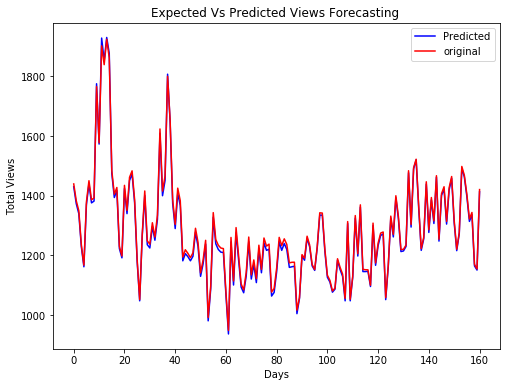

In [90]:
plot.figure(figsize=(8, 6))
labels={'Predicted','original'}
plot.plot(inv_y, color= 'blue')
plot.plot(inv_yhat, color = 'red')
plot.title('Expected Vs Predicted Views Forecasting ')
plot.xlabel('Days')
plot.ylabel('Total Views')
plot.legend(labels)
plot.show()